In [1]:
import sys 
import torch
import os
sys.path.append('../..')

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pytorch_lightning as pl
from src.datasets.vqa_rad_clef_mixed_dataset import RAD_CLEF_Mixed_DataModule
from src.models.multimodal.flamingo_module import FlamingoModule
from tqdm import tqdm

from pytorch_lightning import Trainer, seed_everything
import torchvision.transforms as T

from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning import loggers as pl_loggers

seed_everything(42, workers=True)

img_mean = (0.2570, 0.2570, 0.2570)
img_std = (0.2710, 0.2710, 0.2710)

transforms = {
    'train':
    T.Compose(
    [
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=img_mean, std=img_std)
    ]),
    'test':
    T.Compose(
    [
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=img_mean, std=img_std)
    ]),
    'val':
    T.Compose(
    [
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=img_mean, std=img_std)
    ])
}


/home/mlmi-matthias/anaconda3/envs/mlmi_caghan/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


In [2]:
# Hyperparameters
NUM_DATA_WORKERS  = 8
ONLY_IMAGES = False
BATCH_SIZE = 1
NUM_EPOCHS = 10
LIMIT_NUM_SAMPLES = 500

ACCELERATOR = "gpu"
DEVICES = [1]
# ACCELERATOR = "cpu"
# DEVICES = 1
PRETRAINED_CLIP_PATH = '/home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth'
PRETRAINED_GPT2_PATH = "/home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin"

IMAGE_TYPE = "jpg"
SHUFFLE = True
TOKENIZER  = "gpt2"
LOAD_IN_MEM = True
PREPROCESSED = True

vqarad_datamodule = RAD_CLEF_Mixed_DataModule(
                                batch_size=BATCH_SIZE, transforms=transforms,
                                limit_num_samples=LIMIT_NUM_SAMPLES, num_data_workers=NUM_DATA_WORKERS,
                                tokenizer="gpt2", 
)

CLEF data length 500
RAD data length 1574


In [3]:
train_loader = vqarad_datamodule.train_dataloader()
val_loader = vqarad_datamodule.val_dataloader()
test_loader = vqarad_datamodule.test_dataloader()

In [4]:
for batch in train_loader:
    cur_images = batch['image']
    print(cur_images.shape)
    break

torch.Size([1, 3, 224, 224])


In [5]:

total_mean = (0.2570, 0.2570, 0.2570)
total_std = (0.2710, 0.2710, 0.2710)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: (0.257, 0.257, 0.257)
std:  (0.271, 0.271, 0.271)


In [6]:
# MODEL HPRAMS
VOCAB_SIZE_OF_TOKENIZER = 50257 # mimic_datamodule.train_dataset.tokenizer.vocab_size
LANGUAGE_MODEL = 'gpt2'
NUM_TOKENS = VOCAB_SIZE_OF_TOKENIZER +3 if LANGUAGE_MODEL=="gpt2" else 31092
FLAMINGO_EMBED_DIM = 768
DEPTH = 12
NUM_HEADS = 8
ATT_HEAD_DIM = 64
CROOS_ATT_EVERY=3
MEDIA_TOKEN_ID = vqarad_datamodule.tokenizer.\
    all_special_ids[vqarad_datamodule.tokenizer.all_special_tokens.index('<image>')]
PERCEIVER_NUM_LATENTS = 64
PERCEIVER_DEPTH = 2
IMAGE_ENCODER = "clip"



print("LANGUAGE_MODEL : ",LANGUAGE_MODEL, "\n"
        "NUM_TOKENS : ",NUM_TOKENS, "\n"
        "FLAMINGO_EMBED_DIM : ",FLAMINGO_EMBED_DIM, "\n"
        "DEPTH : ",DEPTH, "\n"
        "NUM_HEADS : ",NUM_HEADS, "\n"
        "ATT_HEAD_DIM : ",ATT_HEAD_DIM, "\n"
        "CROOS_ATT_EVERY : ",CROOS_ATT_EVERY, "\n"
        "MEDIA_TOKEN_ID : ",MEDIA_TOKEN_ID, "\n"
        "PERCEIVER_NUM_LATENTS : ",PERCEIVER_NUM_LATENTS, "\n"
        "PERCEIVER_DEPTH : ",PERCEIVER_DEPTH, "\n"
        "IMAGE_ENCODER : ",IMAGE_ENCODER, "\n"
        "PRETRAINED_CLIP_PATH : ",PRETRAINED_CLIP_PATH, "\n"
        "PRETRAINED_GPT2_PATH : ",PRETRAINED_GPT2_PATH, "\n")


hyperparams = {
    'pretrained_clip_path': PRETRAINED_CLIP_PATH,
    'warmup_steps': 0,
    'num_tokens': NUM_TOKENS,
    'dim': FLAMINGO_EMBED_DIM,
    'depth': DEPTH,
    'num_heads': NUM_HEADS,
    'dim_head': ATT_HEAD_DIM,
    'cross_attn_every': CROOS_ATT_EVERY,
    'media_token_id': MEDIA_TOKEN_ID,
    'perceiver_num_latents': PERCEIVER_NUM_LATENTS,
    'perceiver_depth': PERCEIVER_DEPTH,
    'image_encoder': IMAGE_ENCODER,
    'language_model': LANGUAGE_MODEL,
    'pretrained_gpt2_path': PRETRAINED_GPT2_PATH,
}


model = FlamingoModule(**hyperparams)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpzkx5m01i


LANGUAGE_MODEL :  gpt2 
NUM_TOKENS :  50260 
FLAMINGO_EMBED_DIM :  768 
DEPTH :  12 
NUM_HEADS :  8 
ATT_HEAD_DIM :  64 
CROOS_ATT_EVERY :  3 
MEDIA_TOKEN_ID :  50258 
PERCEIVER_NUM_LATENTS :  64 
PERCEIVER_DEPTH :  2 
IMAGE_ENCODER :  clip 
PRETRAINED_CLIP_PATH :  /home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth 
PRETRAINED_GPT2_PATH :  /home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin 



INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpzkx5m01i/_remote_module_non_sriptable.py


Pretrained clip is being loaded
Flamingo is being initialized with  gpt2  as language model
GPT 2 Weights are loading...
Loaded GPT2 weights and Embeddings num_weights loaded :  156


In [7]:
CHECKPOINT_PATH = "/home/mlmi-matthias/Fabian/mlmi-vqa/notebooks/lightning_logs/version_1/checkpoints/epoch=4-val_loss=1.42-other_metric=0.00.ckpt"
START_FROM_CHECKPOINT = True

if START_FROM_CHECKPOINT:
    print("Pretrained Flamingo Model is loaded from checkpoint : ",CHECKPOINT_PATH)
    model.load_state_dict(torch.load(CHECKPOINT_PATH)["state_dict"])

Pretrained Flamingo Model is loaded from checkpoint :  /home/mlmi-matthias/Fabian/mlmi-vqa/notebooks/lightning_logs/version_1/checkpoints/epoch=4-val_loss=1.42-other_metric=0.00.ckpt


In [8]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
import numpy as np

from torch import nn as nn
import torch.nn.functional as F
def generate(image, context, cur_model, ntok=20):
    for _ in range(ntok):
        out = cur_model({'image': image,'input_ids': context })
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        next_tok = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        context = torch.cat([context, next_tok.unsqueeze(-1)], dim=-1)
    return context


tokenizer = vqarad_datamodule.tokenizer

In [9]:
val_loader_iter = iter(val_loader)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: " + batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])

Model out :  <|endoftext|> <image> question: What organ is superimposed on the lung fields? answer: <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: Breasts


In [12]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])

Model out :  <|endoftext|> <image> question: what abnormality is seen in the image? answer: adenoma of the coracic vein <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: transitional cell carcinoma, bladder


In [13]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])

Model out :  <|endoftext|> <image> question: What is the location of the mass answer: the primary abnormality in the primary abnormality is abnormal area of the ctissue <EOC>[PAD]
Correct Answer: anterior to the transverse colon


Model out :  <|endoftext|> <image> question: what is the primary abnormality in this image? answer: adesophageal obstruction of the ct scan?enhanced is seen in the ct
Correct Answer: acute appendicitis


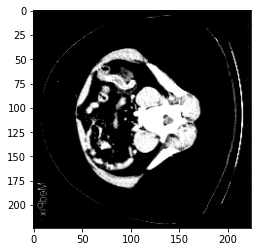

In [14]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])
plt.imshow(torch.swapaxes(val_img.squeeze(0),0,2), cmap='Greys')

Model out :  <|endoftext|> <image> question: Is the left renal cyst uniform? answer: no <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: Yes


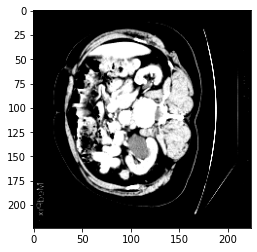

In [15]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])
plt.imshow(torch.swapaxes(val_img.squeeze(0),0,2), cmap='Greys')

Model out :  <|endoftext|> <image> question: what is abnormal in the mri? answer: hypoxyloma? answer: lymphoma? answer: no <EOC>[PAD][PAD][PAD][PAD][PAD]
Correct Answer: hemangioma, soft-tissue


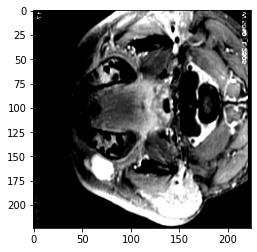

In [16]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])
plt.imshow(torch.swapaxes(val_img.squeeze(0),0,2), cmap='Greys')

Model out :  <|endoftext|> <image> question: where is the mass located? answer: portal veins (intum? answer: lymphoma <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: anterior to the transverse colon


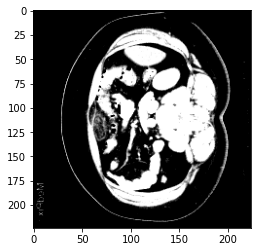

In [17]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])
plt.imshow(torch.swapaxes(val_img.squeeze(0),0,2), cmap='Greys')